In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import timeit
from sklearn.metrics import mean_squared_error
import math
import spgl1 as spgl1
from sklearn.linear_model import orthogonal_mp
import pywt
from data_matrices import *
from sys import getsizeof
#import DLIPsim as dlip
import inspect
from pprint import pprint
import warnings
from cs_utils import *
warnings.filterwarnings('ignore')

In [2]:
rugosity = 0.1
target='elliptical'
SNR = 1e1 # 0dB
#1e4#40 #dB
SNR_dB = int(10*np.log10(SNR))
print(SNR_dB)
c = 0.3 #0.299792458 # Velocidad de la luz (x 1e9 m/s)
fc = 15 # Frecuencia Central(GHz)
BW = 0.6 # Ancho de banda(GHz)
Ls = 1.2 # 4 # 0.6 # Longitud del riel (m)
Ro = 0 # Constante debido al delay de los cables(m)
theta = 90 # Angulo azimuth de vision de la imagen final(grados sexagesimales E [0-90])

10


40 40
150 248 256
40 40 16 16
(256,)


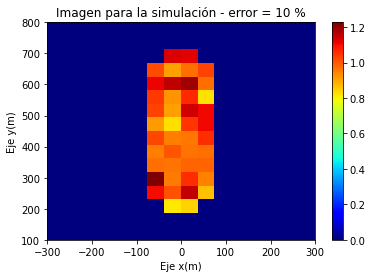

In [3]:
#'elliptical'#'ROJ'#'elliptical'#'ROJ'#'UNI'#'T'#'ROJ'#'UNI'#'T'#'ROJ'
I_t, R_t, x_c,y_c, N_r, N_c, w, h,dw, dh, str_target = SelectTarget(target,rugosity)
# Hallando el Np a partir de los pasos
dp=c/(4.1*fc*np.sin(theta*np.pi/180)) # paso del riel para un angulo de vision de 180°
Np=int(Ls/dp)+1 # Numero de pasos del riel
if Np%2!=0:
    Np+=1   # Para que el numero de pasos sea par
# Hallando el Nf en funcion a la distancia máxima deseada
r_r=c/(2*BW) # resolucion en rango
Nf=150#int(h/r_r) #+1 #Numero de frecuencias
print(Nf,Np,N_r*N_c)
print(dw, dh, N_r, N_c)
print(I_t.shape)

In [4]:
por = 40
per=por/100
Nf_rand = int(per*Nf)
n = Nf_rand  # for 2 random indices
ind = np.random.choice(Nf, n, replace=False)
index = np.sort(ind)
#print(a[index])
#print(a)

In [5]:
vmin, vmax = -100, -20 #dB
Lx,Ly,dx,dy = w,h,dw,dh # Dimensiones de la imagen
x_min, x_max= [-(Lx+dx)/2, (Lx+dx)/2]
y_min, y_max= [0-dy/2,Ly+dy/2]
extent = [x_min,x_max,y_min,y_max]
print(Lx,Ly,dx,dy)
print(Lx/dx+1, Ly/dy+1)
print(extent)
prm={'c':c,'fc':fc,'BW':BW,'Ls':Ls,'Ro':Ro,'theta':theta,'Np':Np,'Nf':Nf,
       'w':w,'h':h,'dw':dw,'dh':dh}

640 640 40 40
17.0 17.0
[-340.0, 340.0, -20.0, 660.0]


In [6]:
#dp=Ls/(Np-1) # Paso del riel(m)
fi=fc-BW/2 # Frecuencia inferior(GHz)
fs=fc+BW/2 # Frecuencia superior(GHz)
# Cálculo de las resoluciones
rr_r=c/(2*BW) # Resolución en rango
rr_a=(c/(2*Ls*fc))*R_t.T[1].max() # Resolución en azimuth
#-----------------VERIFICACIÓN DE CONDICIONES------------------------
# Rango máximo
R_max=Nf*c/(2*BW)
# Paso del riel máximo
dx_max=c/(fc*4*np.sin(theta*np.pi/180)) # Theta en grados sexagesimales
print("------------------------------------------------------")
print("--------------INFORMACIÓN IMPORTANTE------------------")
print("------------------------------------------------------")
print("- Resolución en rango(m) : ", rr_r)
print("- Resolución en azimuth(m): ", rr_a)
print("------------------------------------------------------")
print("- Rango máximo permitido(m): ", R_max)
print("------------------------------------------------------")
print("______¿Se cumplen las siguientes condiciones?_________")
print("Rango máximo del target <= rango máximo?: ", R_t.T[1].max()<=R_max) # Ponerle un try-except
print("Paso del riel <= paso máximo?: ", dp<=dx_max) # Evita el aliasing en el eje de azimuth
print("------------------------------------------------------")


------------------------------------------------------
--------------INFORMACIÓN IMPORTANTE------------------
------------------------------------------------------
- Resolución en rango(m) :  0.25
- Resolución en azimuth(m):  [6.66666667]
------------------------------------------------------
- Rango máximo permitido(m):  37.5
------------------------------------------------------
______¿Se cumplen las siguientes condiciones?_________
Rango máximo del target <= rango máximo?:  [False]
Paso del riel <= paso máximo?:  True
------------------------------------------------------


In [7]:
#----------------OBTENCIÓN DE la historia DE FASE----------------------
#start_time = timeit.default_timer()
Ski = get_phaseH(prm,I_t,R_t)
#print("Tiempo del procesamiento(IP): ",timeit.default_timer() - start_time," s")
data = {'Ski':Ski, 'dp':dp, 'fi':fi, 'fs':fs, 'R_max':R_max}
module_sim = abs(I_t).reshape(N_r,N_c)#20*np.log10(abs(I_t)).reshape(N_r,N_c)#abs(I_t).reshape(N_r,N_c)#
phase_sim = np.zeros(I_t.shape).reshape(N_r,N_c)
#print(extent)
I_sim = I_t.reshape(N_r,N_c)
#print(module_sim.shape)
print('Phase history: ', Ski.shape)

(150,) (248,)
Phase history:  (248, 150)


Text(0.5, 0.98, 'Simulated target (rugosity = 0.100000)')

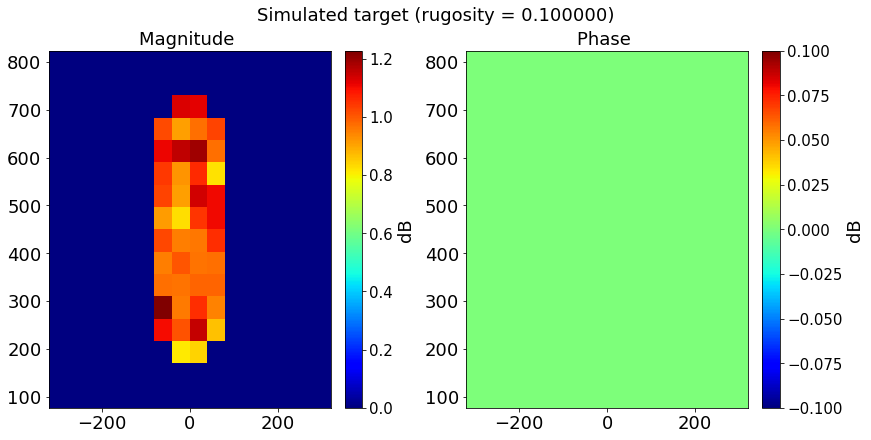

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,6), layout='constrained')
fontsize=18
#clrs = ax.imshow(20*np.log10(np.abs(Im_cs)),origin='lower',cmap='jet',extent=extent)#,vmin=vmin,vmax=vmax)
clrs1 = ax[0].pcolormesh(x_c, y_c,np.abs(I_sim) ,cmap='jet')
box=ax[0].get_position()
#cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb1=plt.colorbar(clrs1,ax=ax[0])#,cax=cbarax)
#cb2 = fig.colorbar(im2)
#cb.set_label(r'$log_{10}SNR$', fontsize=17)
ax[0].set_title('Magnitude ' ,fontsize=fontsize)
cb1.set_label(r'dB', fontsize=fontsize)
cb1.ax.tick_params(labelsize=fontsize-3)
ax[0].xaxis.set_tick_params(labelsize=fontsize)
ax[0].yaxis.set_tick_params(labelsize=fontsize)
#10dB,-50dB/60dB
#'''
clrs2 = ax[1].pcolormesh(x_c, y_c,np.angle(I_sim) ,cmap='jet')
box=ax[1].get_position()
#cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb2=plt.colorbar(clrs2,ax=ax[1])#,cax=cbarax)
#cb2 = fig.colorbar(im2)
#cb.set_label(r'$log_{10}SNR$', fontsize=17)
ax[1].set_title('Phase ' ,fontsize=fontsize)
cb2.set_label(r'dB', fontsize=fontsize)
cb2.ax.tick_params(labelsize=fontsize-3)
ax[1].xaxis.set_tick_params(labelsize=fontsize)
ax[1].yaxis.set_tick_params(labelsize=fontsize)
fig.suptitle('Simulated target (rugosity = %f)' % rugosity,fontsize=fontsize)
#'''

### Determining the noise level from SNR and phase history module

In [9]:
D2 = np.linalg.norm(Ski)**2/(Ski.shape[0]*Ski.shape[1])
n0 = np.sqrt(D2/SNR)
print(SNR)
print(n0)
print(Ski.shape)
fils,cols = Ski.shape
#noise = np.random.normal(scale=1,size=(2,2))
noise_re = np.random.rand(fils,cols)
noise_im = np.random.rand(fils,cols)
noise = n0*(noise_re+1j*noise_im)/np.sqrt(2)
#print(noise)
#print(np.angle(Ski)==np.angle(Ski+noise))

10.0
2.127335833320328
(248, 150)


In [10]:
Ski_noisy = Ski + noise

In [11]:
#Ski = data['Ski'].copy()
fi = data['fi']
fs = data['fs']
# Creation of vector S1
S1 = np.reshape(Ski_noisy.T,(len(Ski)*len(Ski[0]),1)) # Convert Raw Data matrix into vector
riel_p = np.linspace(-Ls/2, Ls/2, Np) # Vector de posiciones
f = np.linspace(fi, fs, Nf) # Vector de frecuencias
ks = 2*np.pi*f/c # Range domain wavenumber
r_c=np.array([(i,j) for j in y_c for i in x_c])
print(SNR_dB)

10


In [12]:
print(Ski_noisy.shape, Nf, Np,SNR_dB)


(248, 150) 150 248 10


Text(0.5, 0.98, 'Phase history - simulated elliptical target - SNR = 10 dB')

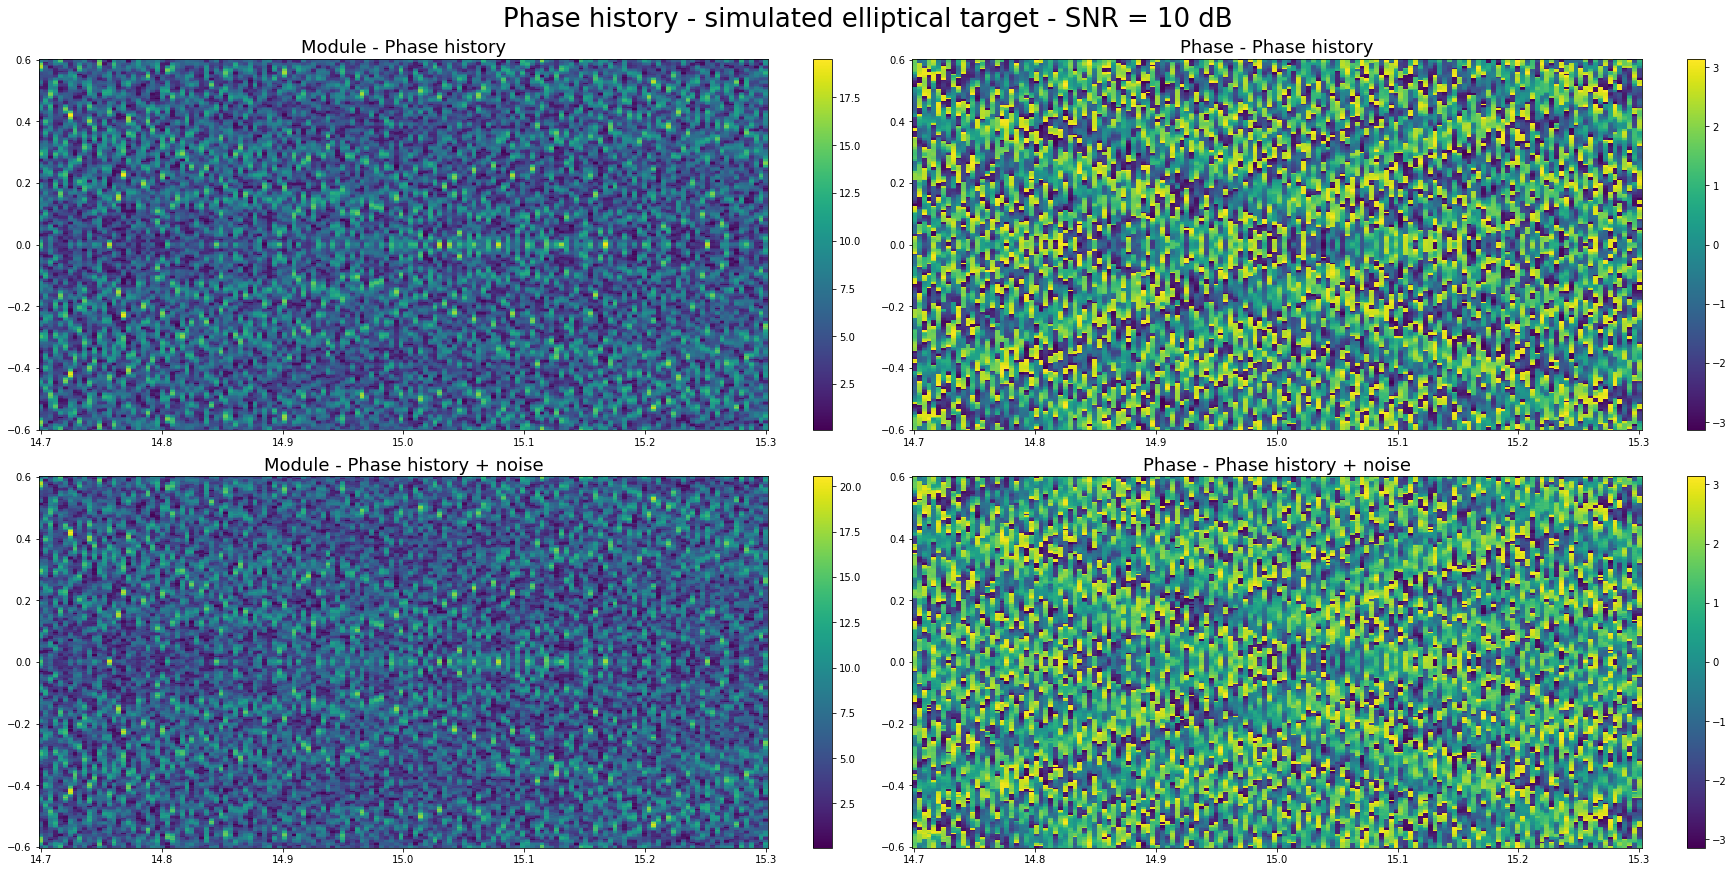

In [13]:
fontsize = 18
fig, ax = plt.subplots(2,2,figsize=(24,12), constrained_layout=True)
#clrs00 = ax[0,0].imshow(np.abs(Ski),origin='lower')
clrs00 = ax[0,0].pcolormesh(f,riel_p,np.abs(Ski))
cb00 = plt.colorbar(clrs00,ax=ax[0,0])
ax[0,0].set_title('Module - Phase history',fontsize=fontsize)
#clrs01 = ax[0,1].imshow(np.angle(Ski),origin='lower')
clrs01 = ax[0,1].pcolormesh(f,riel_p,np.angle(Ski))
cb01 = plt.colorbar(clrs01,ax=ax[0,1])
ax[0,1].set_title('Phase - Phase history',fontsize=fontsize)

#clrs10 = ax[1,0].imshow(np.abs(Ski_noisy),origin='lower')
clrs10 = ax[1,0].pcolormesh(f,riel_p,np.abs(Ski_noisy))
cb10 = plt.colorbar(clrs10,ax=ax[1,0])
ax[1,0].set_title('Module - Phase history + noise',fontsize=fontsize)
#clrs11 = ax[1,1].imshow(np.angle(Ski_noisy),origin='lower')
clrs11 = ax[1,1].pcolormesh(f,riel_p,np.angle(Ski_noisy))
cb11 = plt.colorbar(clrs11,ax=ax[1,1])
ax[1,1].set_title('Phase - Phase history + noise',fontsize=fontsize)
fig.suptitle("Phase history - simulated elliptical target - SNR = %d dB" % SNR_dB,fontsize=fontsize+8)
#fig.tight_layout()

In [14]:
A_rand = np.zeros((Np*Nf_rand,len(r_c)), dtype=complex)
f_rand = f[index]
Ski_rand_aux = Ski_noisy[:,index].flatten()
c = 0.3
ks = 2*np.pi*f_rand/c #
    #print('Dimensiones de I_t: ', I_t.shape)
for n in range(len(r_c)):
    m = 0
    for s in range(len(f_rand)):
        for l in range(len(riel_p)):
            A_rand[m,n] = np.exp(-2j*ks[s]*np.abs(distance_nk(r_c[n],riel_p[l])))
            m+=1
Ski_r = Ski_rand_aux#np.array([sum(I_t[i]*np.exp(-1j*4*np.pi*fi*distance_nk(R_t[i],xi)/c) for i in range(len(I_t))) for xi in riel_p_rand for fi in f]) # Create a vector with value for each fi y ri
Ski_rand = np.reshape(Ski_r,(Np,Nf_rand)) # Reshape the last vector Sr_f
S1_rand = np.reshape(Ski_rand.T,(len(Ski_rand)*len(Ski_rand[0]),1))
b_rand = S1_rand.copy()

### Checking if the transformation matrix is orthogonal:

In [15]:
#A_rand, b_rand =  UnderSample(r_c,riel_p,R_t,Nf,Np,per,Ski_noisy,f)
print(A_rand.shape, b_rand.shape)
N = A_rand.shape[1]#b_rand.shape[0]
wavelet = 'db2'
mode = 'periodization'#['zero', 'constant', 'symmetric', 'periodic', 'smooth', 'periodization', 'reflect', 'antisymmetric', 'antireflect']
Psi = WaveletMatrix(wavelet,N)
ar = Psi.T@Psi
print("Is it diagonal? ", np.array_equal(ar, np.diag(np.diag(ar))))
identity = np.array(np.identity((ar.shape[0])),dtype=float)
print('Psi@Psi.T is the identity: ')
ar[ar<1e-15]=0
print(ar==identity)
print(ar)
print(identity)

(14880, 256) (14880, 1)
Is it diagonal?  False
Psi@Psi.T is the identity: 
[[False  True  True ...  True  True  True]
 [ True False  True ...  True  True  True]
 [ True  True False ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [16]:
wavelet = 'db2'
sigma   = n0#np.sqrt(n0**2*(Ski_noisy.shape[0]*Ski_noisy.shape[1])) #1e-18
#sigma2  = 1e-3#0.1
N = A_rand.shape[1]
Psi = WaveletMatrix(wavelet,N)
A_i = np.imag(np.dot(A_rand,Psi))
A_r = np.real(np.dot(A_rand,Psi))
b_i = np.imag(b_rand)
b_r = np.real(b_rand)
Aug = np.block([[A_r, -A_i],[A_i, A_r]])
baug = np.concatenate((b_r,b_i),axis=0)
print("BPDN: ", Aug.shape, baug.shape)


BPDN:  (29760, 512) (29760, 1)


In [17]:
xaug,raug,gaug,info = spgl1.spg_bpdn(Aug, baug.flatten(), sigma)
x = xaug[0:N] + 1j*xaug[N:]
x_mp = Psi@x
x_f = np.reshape(x_mp,(len(y_c),len(x_c)))

print(por)

40


In [18]:
from sklearn.metrics import mean_squared_error
rmse_mag = math.sqrt(mean_squared_error(np.abs(x_f),module_sim))
rmse_phase = math.sqrt(mean_squared_error(np.angle(x_f),phase_sim))
print(rmse_mag,rmse_phase)

0.005033865426773376 1.6966733240453546


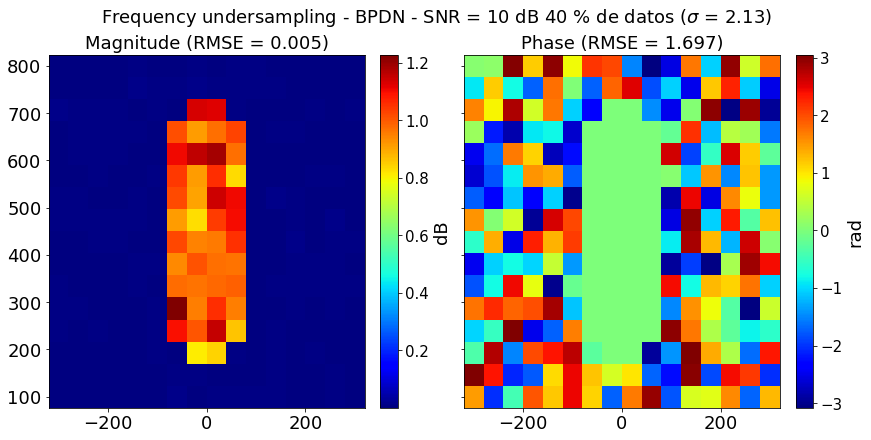

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12,6),layout='constrained',sharey=True)
fontsize=18

#clrs = ax.imshow(20*np.log10(np.abs(Im_cs)),origin='lower',cmap='jet',extent=extent)#,vmin=vmin,vmax=vmax)
#clrs1 = ax[0].pcolormesh(x_c, y_c,20*np.log10(np.abs(x_40_bpdn)) ,cmap='jet')
clrs1 = ax[0].pcolormesh(x_c, y_c,np.abs(x_f) ,cmap='jet')
box=ax[0].get_position()
#cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb1=plt.colorbar(clrs1,ax=ax[0])#,cax=cbarax)
#cb2 = fig.colorbar(im2)
#cb.set_label(r'$log_{10}SNR$', fontsize=17)
ax[0].set_title('Magnitude (RMSE = %.3f)' % rmse_mag,fontsize=fontsize)
cb1.set_label(r'dB', fontsize=fontsize)
cb1.ax.tick_params(labelsize=fontsize-3)
ax[0].xaxis.set_tick_params(labelsize=fontsize)
ax[0].yaxis.set_tick_params(labelsize=fontsize)
#10dB,-50dB/60dB
#'''
clrs2 = ax[1].pcolormesh(x_c, y_c,np.angle(x_f) ,cmap='jet')
box=ax[1].get_position()
#cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb2=plt.colorbar(clrs2,ax=ax[1])#,cax=cbarax)
#cb2 = fig.colorbar(im2)
#cb.set_label(r'$log_{10}SNR$', fontsize=17)
ax[1].set_title('Phase (RMSE = %.3f)' % rmse_phase,fontsize=fontsize)
cb2.set_label(r'rad', fontsize=fontsize)
cb2.ax.tick_params(labelsize=fontsize-3)
ax[1].xaxis.set_tick_params(labelsize=fontsize)
ax[1].yaxis.set_tick_params(labelsize=fontsize)
fig.suptitle('Frequency undersampling - BPDN - SNR = %d dB %d %% de datos ($\sigma$ = %.2f)' % (SNR_dB,por,sigma) ,fontsize=fontsize)
str_aux = 'bpdn-snr-%d-dB-%d-percent.png' % (SNR_dB,por)
plt.savefig('reco-undersampling-freq-%s' % str_aux,bbox_inches='tight')
#print(np.min(20*np.log10(np.abs(x_40_bpdn))),np.max(20*np.log10(np.abs(x_40_bpdn))))

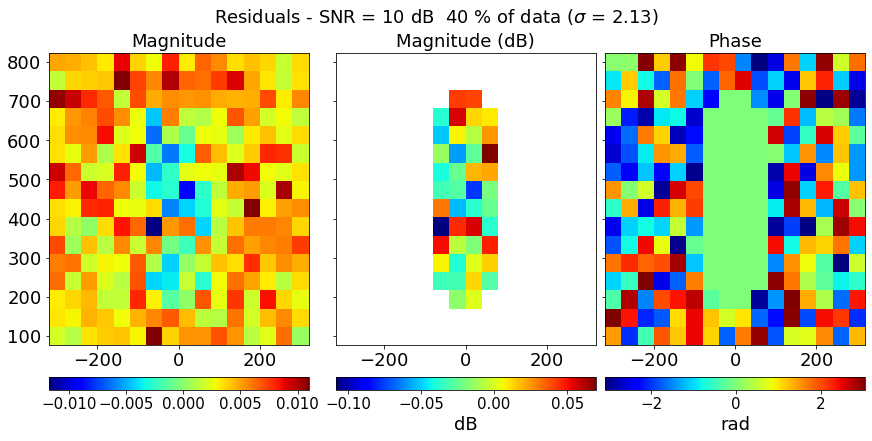

In [20]:
x_40_bpdn = x_f.copy()
fig, ax = plt.subplots(1,3,figsize=(12,6),layout='constrained',sharey=True)
fontsize=18
pad=0.02
clrs0 = ax[0].pcolormesh(x_c, y_c,np.abs(x_40_bpdn)-module_sim ,cmap='jet')
box=ax[0].get_position()
#cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb0=plt.colorbar(clrs0,ax=ax[0],orientation="horizontal", pad=pad)#,cax=cbarax)
#cb2 = fig.colorbar(im2)
#cb.set_label(r'$log_{10}SNR$', fontsize=17)
ax[0].set_title('Magnitude',fontsize=fontsize)
#cb1.set_label(r'', fontsize=fontsize)
cb0.ax.tick_params(labelsize=fontsize-3)
ax[0].xaxis.set_tick_params(labelsize=fontsize)
ax[0].yaxis.set_tick_params(labelsize=fontsize)

clrs1 = ax[1].pcolormesh(x_c, y_c,20*np.log10(np.abs(x_40_bpdn))-20*np.log10(module_sim) ,cmap='jet')
box=ax[1].get_position()
#cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb1=plt.colorbar(clrs1,ax=ax[1],orientation="horizontal", pad=pad)#,cax=cbarax)
#cb2 = fig.colorbar(im2)
#cb.set_label(r'$log_{10}SNR$', fontsize=17)
ax[1].set_title('Magnitude (dB)',fontsize=fontsize)
cb1.set_label(r'dB', fontsize=fontsize)
cb1.ax.tick_params(labelsize=fontsize-3)
ax[1].xaxis.set_tick_params(labelsize=fontsize)
ax[1].yaxis.set_tick_params(labelsize=fontsize)
#10dB,-50dB/60dB
#'''
clrs2 = ax[2].pcolormesh(x_c, y_c,np.angle(x_40_bpdn)-phase_sim ,cmap='jet')
box=ax[2].get_position()
cb2=plt.colorbar(clrs2,ax=ax[2],orientation="horizontal", pad=pad)#,cax=cbarax)
ax[2].set_title('Phase',fontsize=fontsize)
cb2.set_label(r'rad', fontsize=fontsize)
cb2.ax.tick_params(labelsize=fontsize-3)
ax[2].xaxis.set_tick_params(labelsize=fontsize)
ax[2].yaxis.set_tick_params(labelsize=fontsize)
fig.suptitle(r'Residuals - SNR = %d dB  %d %% of data ($\sigma$ = %.2f)' % (SNR_dB,por,sigma),fontsize=fontsize)
#'''
plt.savefig('residuals-%s' % str_aux,bbox_inches='tight')

### Undersampling manual

In [23]:
wavelets = ['db2','db4','haar','coif2','sym2']
#['db2', 'haar']
#['db2','db4','haar','coif2','sym2']
list_err_mag = []
list_err_phase = []
list_psnr = []
list_err_mag_spgl1 = []
list_err_phase_spgl1 = []
list_psnr_spgl1 = []
cut_off = 0.5
for wv in wavelets:
    print('Wavelet: ',wv)
    mag_err, phase_err,psnr_vector =  GetErrors(x_c,y_c,r_c,riel_p,R_t,Nf,Np,per,Ski,wv,f,sigma**2,R_100,I_sim,cut_off, str_target)
    spgl1_mag_err, spgl1_phase_err,spgl1_psnr_vector =  GetErrorsSPGL1(x_c,y_c,r_c,riel_p,R_t,Nf,Np,per,Ski,wv,f,sigma,R_100, I_sim, cut_off, str_target)
    list_err_mag.append(mag_err)
    print("Phase error: ", phase_err)
    list_err_phase.append(phase_err)
    list_psnr.append(psnr_vector)
    list_err_mag_spgl1.append(spgl1_mag_err)
    list_err_phase_spgl1.append(spgl1_phase_err)
    list_psnr_spgl1.append(spgl1_psnr_vector)

Wavelet:  db2


NameError: name 'R_100' is not defined

In [ ]:
pers = np.linspace(5,100,20)/100
#pers = np.linspace(10,100,5)/100
fontsize=20
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(wavelets)):
    #if i!=2:
    #    continue
    ax.plot(10*np.log10(pers),list_err_mag[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$10log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('RMSE',fontsize=fontsize)
    ax.set_title('RMSE - Magnitude (OMP) - Target %s' % str_target.upper(),fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
plt.savefig('target-%s-rmse-magnitude-omp-different-basis.png' % str_target,bbox_inches='tight')    

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(wavelets)):
    ax.plot(10*np.log10(pers),list_err_phase[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$10log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('RMSE',fontsize=fontsize)
    ax.set_title('RMSE - Phase (OMP) - Target %s' % str_target.upper(),fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
plt.savefig('target-%s-rmse-phase-omp-different-basis.png' % str_target.upper(),bbox_inches='tight')    

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(wavelets)):
    #if i==2:
    #    continue
    ax.plot(10*np.log10(pers),list_psnr[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$10log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('PSNR (dB)',fontsize=fontsize)
    ax.set_title('PSNR (OMP) - Target %s' % str_target.upper(),fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
#ax.plot(x_fit, y_fit,label='linear fit',lw=4,marker='v')
ax.legend(fontsize=fontsize)
plt.savefig('target-%s-psnr-phase-omp-different-basis.png' % str_target,bbox_inches='tight')    

In [ ]:
#pers = np.linspace(4,100,20)/100
#pers = np.linspace(10,100,5)/100
fontsize=20
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(wavelets)):
    ax.plot(np.log10(pers),list_err_mag_spgl1[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('RMSE',fontsize=fontsize)
    ax.set_title('RMSE - Magnitude (BPDN) - Target %s' % str_target.upper(),fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
plt.savefig('target-%s-rmse-magnitude-spgl1-different-basis.png' % str_target,bbox_inches='tight')    

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(wavelets)):
    ax.plot(np.log10(pers),list_err_phase_spgl1[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('RMSE',fontsize=fontsize)
    ax.set_title('RMSE - Phase (BPDN) - Target %s' % str_target.upper(),fontsize=fontsize)
    ax.legend(fontsize=fontsize,loc='best')
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
plt.savefig('target-%s-rmse-phase-spgl1-different-basis.png' % str_target,bbox_inches='tight')    

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(wavelets)):
    #if i==2:
    #    continue
    ax.plot(np.log10(pers),list_psnr_spgl1[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('PSNR',fontsize=fontsize)
    ax.set_title('PSNR (BPDN) - Target %s' % str_target.upper(),fontsize=fontsize)
    #ax.set_title('PSNR (BPDN)',fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
plt.savefig('psnr-phase-spgl1-different-basis.png',bbox_inches='tight')    

### Many data realizations

In [ ]:
wavelets = ['db2','db4','haar','coif2','sym2']
['db2', 'coif2']#,'coif2']
#['db2','db4','haar','coif2','sym2']

list_err_mag = []
list_err_phase = []
list_psnr = []
list_err_mag_spgl1 = []
list_err_phase_spgl1 = []
list_psnr_spgl1 = []

list_err_mag_std = []
list_err_phase_std = []
list_psnr_std = []
list_err_mag_spgl1_std = []
list_err_phase_spgl1_std = []
list_psnr_spgl1_std = []

cut_off = 0.5
#print(Ski.shape)
fils,cols = Ski.shape
numRealizations = 10#10
#noise = np.random.normal(scale=1,size=(2,2))
#noise_re = np.random.rand(fils,cols)
#noise_im = np.random.rand(fils,cols)
#noise = n0*(noise_re+1j*noise_im)
D2 = np.linalg.norm(Ski)**2/(Ski.shape[0]*Ski.shape[1])
print(D2)
n0 = np.sqrt(D2/SNR)
sigma   = np.sqrt(n0**2*(Ski_noisy.shape[0]*Ski_noisy.shape[1]))
print(n0)
print(Ski.shape)
fils,cols = Ski.shape
for wv in wavelets:
    print("*************************************************")
    print('Wavelet: ',wv)
    mag_err_temp = []
    phase_err_temp = []
    psnr_temp = []
    spgl1_mag_err_temp = []
    spgl1_phase_err_temp = []
    spgl1_psnr_temp = []
    for i in range(numRealizations):
        print("Realization number: ", i)
        noise = n0*(np.random.rand(fils,cols)+1j*np.random.rand(fils,cols))
        Ski_noisy = Ski + noise
        mag_err, phase_err,psnr_vector =  GetErrors(x_c,y_c,r_c,riel_p,R_t,Nf,Np,per,Ski_noisy,wv,f,sigma**2,R_100,I_sim,cut_off, str_target)
        spgl1_mag_err, spgl1_phase_err,spgl1_psnr_vector =  GetErrorsSPGL1(x_c,y_c,r_c,riel_p,R_t,Nf,Np,per,Ski_noisy,wv,f,sigma,R_100, I_sim, cut_off, str_target)
        mag_err_temp.append(mag_err)
        phase_err_temp.append(phase_err)
        psnr_temp.append(psnr_vector)
        spgl1_mag_err_temp.append(spgl1_mag_err)
        spgl1_phase_err_temp.append(spgl1_phase_err)
        spgl1_psnr_temp.append(spgl1_psnr_vector)
        print("Phase errors inside the loop: ",phase_err)
    mag_err_avg = np.nanmean(mag_err_temp,axis=0)
    phase_err_avg = np.nanmean(phase_err_temp,axis=0)
    psnr_vector_avg = np.nanmean(psnr_temp,axis=0)
    spgl1_mag_err_avg = np.nanmean(spgl1_mag_err_temp,axis=0)
    spgl1_phase_err_avg = np.nanmean(spgl1_phase_err_temp,axis=0)
    spgl1_psnr_vector_avg = np.nanmean(spgl1_psnr_temp,axis=0)
    ###Faltan agregar vectores de std
    mag_err_std = np.nanstd(mag_err_temp,axis=0)
    phase_err_std = np.nanstd(phase_err_temp,axis=0)
    psnr_vector_std = np.nanstd(psnr_temp,axis=0)
    spgl1_mag_err_std = np.nanstd(spgl1_mag_err_temp,axis=0)
    spgl1_phase_err_std = np.nanstd(spgl1_phase_err_temp,axis=0)
    spgl1_psnr_vector_std = np.nanstd(spgl1_psnr_temp,axis=0)
    #######################################################
    print("Average for magnitude, phase error and psnr (OMP): ", mag_err_avg, phase_err_avg, psnr_vector_avg)
    print("Std for magnitude, phase error and psnr (OMP): ", mag_err_std, phase_err_std, psnr_vector_std)
    
    print("Average for magnitude, phase error and psnr (BPDN): ", spgl1_mag_err_avg, spgl1_phase_err_avg, spgl1_psnr_vector_avg)
    print("Std for magnitude, phase error and psnr (BPDN): ", spgl1_mag_err_std, spgl1_phase_err_std, spgl1_psnr_vector_std)
    
    list_err_mag.append(mag_err_avg)
    list_err_phase.append(phase_err_avg)
    list_psnr.append(psnr_vector_avg)
    list_err_mag_spgl1.append(spgl1_mag_err_avg)
    list_err_phase_spgl1.append(spgl1_phase_err_avg)
    list_psnr_spgl1.append(spgl1_psnr_vector_avg)
    
    list_err_mag_std.append(mag_err_std)
    list_err_phase_std.append(phase_err_std)
    list_psnr_std.append(psnr_vector_std)
    list_err_mag_spgl1_std.append(spgl1_mag_err_std)
    list_err_phase_spgl1_std.append(spgl1_phase_err_std)
    list_psnr_spgl1_std.append(spgl1_psnr_vector_std)

In [ ]:
fontsize=20
fig, ax = plt.subplots(figsize=(12,6))
pers = np.linspace(5,100,20)/100
for i in range(len(wavelets)):
    #if i!=2:
    #    continue
    ax.errorbar(10*np.log10(pers),list_err_mag[i],yerr=list_err_mag_std[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$10log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('RMSE',fontsize=fontsize)
    ax.set_title('RMSE - Magnitude (OMP) - Target %s (SNR=%d dB)' % (str_target.upper(),SNR_db),fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
plt.savefig('target-%s-rmse-magnitude-omp-different-basis-with-errors-snr=%d.png' % (str_target,SNR_db),bbox_inches='tight')    

In [ ]:
list_err_phase[1]

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(wavelets)):
    ax.errorbar(np.log10(pers),list_err_phase[i],yerr=list_err_phase_std[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$10log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('RMSE',fontsize=fontsize)
    ax.set_title('RMSE - Phase (OMP) - Target %s (SNR=%d dB)' % (str_target.upper(),SNR_db),fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
plt.savefig('target-%s-rmse-phase-omp-different-basis-with-errors-snr=%d.png' % (str_target.upper(),SNR_db),bbox_inches='tight')    

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(wavelets)):
    #if i==2:
    #    continue
    ax.errorbar(np.log10(pers),list_psnr[i],yerr=list_psnr_std[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$10log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('PSNR (dB)',fontsize=fontsize)
    ax.set_title('PSNR (OMP) - Target %s (SNR=%d dB)' % (str_target.upper(),SNR_db),fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
#ax.plot(x_fit, y_fit,label='linear fit',lw=4,marker='v')
ax.legend(fontsize=fontsize)
plt.savefig('target-%s-psnr-phase-omp-different-basis-with-errors-snr=%d.png' % (str_target,SNR_db),bbox_inches='tight')    

In [ ]:
fontsize=20
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(wavelets)):
    ax.errorbar(np.log10(pers),list_err_mag_spgl1[i],yerr=list_err_mag_spgl1_std[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('RMSE',fontsize=fontsize)
    ax.set_title('RMSE - Magnitude (BPDN) - Target %s (SNR=%d dB)' % (str_target.upper(),SNR_db),fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
plt.savefig('target-%s-rmse-magnitude-spgl1-different-basis-with-errors-snr=%d.png' % (str_target,SNR_db),bbox_inches='tight')    

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(wavelets)):
    ax.errorbar(np.log10(pers),list_err_phase_spgl1[i],yerr=list_err_phase_spgl1_std[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('RMSE',fontsize=fontsize)
    ax.set_title('RMSE - Phase (BPDN) - Target %s (SNR=%d dB)' % (str_target.upper(), SNR_db),fontsize=fontsize)
    ax.legend(fontsize=fontsize,loc='best')
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
plt.savefig('target-%s-rmse-phase-spgl1-different-basis-with-errors-snr=%d.png' % (str_target,SNR_db),bbox_inches='tight')    

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for i in range(len(wavelets)):
    #if i==2:
    #    continue
    ax.errorbar(np.log10(pers),list_psnr_spgl1[i],yerr=list_psnr_spgl1_std[i],label=wavelets[i],marker='o')
    #ax.set_xlabel('%% of data',fontsize=fontsize)
    ax.set_xlabel(r'$log_{10}(M/N)$',fontsize=fontsize)
    ax.set_ylabel('PSNR',fontsize=fontsize)
    ax.set_title('PSNR (BPDN) - Target %s (SNR=%d dB)' % (str_target.upper(), SNR_db),fontsize=fontsize)
    #ax.set_title('PSNR (BPDN)',fontsize=fontsize)
    ax.legend(fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
plt.savefig('target-%s-psnr-phase-spgl1-different-basis-with-errors-snr=%d.png'%(str_target,SNR_db),bbox_inches='tight')    